# Hip Hop Popularity
### *Building a predictive model*

## Summary
In this project, I sought to build a tool that could help my cousin, a hip hop artist, to 

## Business Problem
KC Makes Music is the stage name for my cousin, who is a hip hop artist on spotify. I thought it would make for an interesting learning experience if I used my data science skills to try and help him gain listeners on the platform. He has had some success, but understanding what to do to gain monthly listeners and gain a following tends towards the arcane. Spotify has an extremely robust database, so I knew there was an opportunity here to help my cousin increase his listener base, and therefore expand his reach as an artist.

After looking at the available angles for this project, I decided that one way to go about this was to survey recent hop hop tracks and try to build a model that could predict if a previously unreleased song had potential to be popular in the current scene. I would gather a random assortment of songs (of all popularity scores), take their preview audio files, transform them into spectrograms, and then feed them through a neural network. This would, hopefully, provide a model that has picked up on common features among the popular songs such that it could tell if a new song would be popular. My cousin has a number of unreleased, finished tracks which we could put through the model. If it's accurate enough, it could determine which of the tracks would do well. If none of them do well, it would signal to my cousin that his tracks could use more work, and we could re-test them in an iterative manner. Furthermore, I could use LIME to determine what in particular the model is finding important and pass that information along to my cousin, to focus on.

In this project, it is most important that the model can separate between the two classes. Having a model that mixes up popular and unpopular songs is useless. A false positive means that my cousin releases a song that won't do well, and a false negative means that my cousin overproduces a song that is good as it was. Either way, we ruin good work. With this in mind, accuracy is a useful metric, but ROC-AUC is the preferred metric to use, as it measures how well the two classes can be separated.

## Data Understanding
All data comes from Spotify. Using [Spotipy, a python interface for the Spotify web API,](https://spotipy.readthedocs.io/en/2.19.0/#) I gathered information on random songs in the genre "hip-hop" released 2019-2021. Random tracks were generated adapting a method outlined [here](https://perryjanssen.medium.com/getting-random-tracks-using-the-spotify-api-61889b0c0c27). The data included an http link to a ~30 second mp3 preview audio file, and a popularity score. This score ranged 0-100, with 100 being the most popular. Popularity was trimodal, with a huge peak at 0, a small peak at ~28 and a large peak at ~45.

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import numpy as np
np.random.seed(42)

import pandas as pd
pd.set_option('display.max_columns', None)

import ast

In [ ]:
def randotrack():
    '''
    A function to generate a random track string for the Spotify database request.
    
    Inputs:
    None
    
    Returns:
    A random character from all available with a wildcard character (%) either
    at the beginning, the end, or both
    '''
    # all available characters
    chars = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    # get random character
    randnum = np.random.randint(0,62)
    randchar = chars[randnum]
    # wildcard at beginning, end, or botha
    wildnum = np.random.randint(0,3)
    if wildnum == 0:
        return '%' + randchar
    if wildnum == 1:
        return randchar + '%'
    if wildnum == 2:
        return '%' + randchar + '%'

In [ ]:
rap = sp.search(q=f"genre:hip-hop year:2020-2021 track:{randotrack()}", market='US')

A typical `search` request looks like the above. The query includes the tags `genre`, `year`, and `track`. There are a metric ton of available hip-hop tracks in the past 3 years. A search with `track:` any character turns up 10,000 tracks every time. There is an `offset` argument that specifies the index with which to start listing songs. More popular tracks come up first, but offset only goes to ~990 w/ limit=10. Therefore, to get truly random songs, I have to do a random track id, with a random offset. I'll run this many times and collect all the track info in a big list, then transform into a dataframe.

### Filling out dataframes

In [ ]:
def get_tracks(tracknum=10000, limit=50):
    '''
    Gathers required track information from the Spotify API through Spotipy.
    
    Parameters:
    tracknum - int
        Number of unique tracks to gather information for. More than this number causes the
        client to hang.
    limit - int
        Number of tracks per random track search.
    
    Returns:
    Pandas DataFrame containing id, popularity, track name, artists, album name, album type,
    release date, album image, song duration (milliseconds), and preview mp3 http link
    '''
    sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(
        client_id='CLIENT_ID',
        client_secret='CLIENT_SECRET'),
        requests_timeout=50000) # long timeout because the database is tempermental
    # initialize dictionary holding info
    track_dict = {'id': [], 'popularity': [], 'track': [], 'artists': [], 'album_name': [],
                  'album_type': [], 'release_date': [], 'image': [], 'duration_ms': [], 
                  'preview_url': []}
    repeat_id_count = 0 # count of repeated songs
    while len(track_dict['id']) < tracknum:
        search = sp.search(q=f"genre:hip-hop year:2019-2021 track:{randotrack()}",
                           offset=np.random.randint(1001-limit), # random offset
                           limit=limit, market='US')
        for track in search['tracks']['items']:
            if track['id'] in track_dict['id']: # catching song ids already listed
                repeat_id_count += 1
                continue
            for col in track_dict.keys(): # append info to the dictionary value lists
                if col == 'track':
                    track_dict['track'].append(track['name'])
                    continue
                if col == 'artists':
                    track_dict['artists'].append(
                        [a['name'] for a in track['artists']])
                    continue
                if col == 'album_name':
                    track_dict['album_name'].append(track['album']['name'])
                    continue
                if col == 'album_type':
                    track_dict['album_type'].append(
                        track['album']['album_type'])
                    continue
                if col == 'release_date':
                    track_dict['release_date'].append(
                        track['album']['release_date'])
                    continue
                if col == 'image':
                    try:
                        track_dict['image'].append(
                            track['album']['images'][0]['url'])
                        continue
                    except:
                        track_dict['image'].append(np.nan)
                        continue
                track_dict[col].append(track[col])
    print('Repeat ID Count:\n', repeat_id_count)
    return pd.DataFrame(track_dict)

In [ ]:
for i in range(500):
        print(f'Data chunk #{i}...')
        get_tracks().to_csv(f'data/collection_1/track_df{i}.csv')

Data chunk #35...
Repeat ID Count:
 7521
Data chunk #36...
Repeat ID Count:
 7133
Data chunk #37...
Repeat ID Count:
 7225
Data chunk #38...
Repeat ID Count:
 8315
Data chunk #39...
Repeat ID Count:
 6532
Data chunk #40...
Repeat ID Count:
 6733
Data chunk #41...
Repeat ID Count:
 7959
Data chunk #42...
Repeat ID Count:
 8657
Data chunk #43...
Repeat ID Count:
 8236
Data chunk #44...
Repeat ID Count:
 8735
Data chunk #45...
Repeat ID Count:
 6949
Data chunk #46...
Repeat ID Count:
 9938
Data chunk #47...
Repeat ID Count:
 8442
Data chunk #48...
Repeat ID Count:
 7947
Data chunk #49...
Repeat ID Count:
 9201
Data chunk #50...
Repeat ID Count:
 7203
Data chunk #51...
Repeat ID Count:
 7517
Data chunk #52...
Repeat ID Count:
 8722
Data chunk #53...
Repeat ID Count:
 7621
Data chunk #54...
Repeat ID Count:
 8320
Data chunk #55...
Repeat ID Count:
 7297
Data chunk #56...
Repeat ID Count:
 7975
Data chunk #57...
Repeat ID Count:
 7871
Data chunk #58...
Repeat ID Count:
 7882
Data chunk #59..

Repeat ID Count:
 8141
Data chunk #233...
Repeat ID Count:
 8997
Data chunk #234...
Repeat ID Count:
 6875
Data chunk #235...
Repeat ID Count:
 6763
Data chunk #236...
Repeat ID Count:
 9035
Data chunk #237...
Repeat ID Count:
 7562
Data chunk #238...
Repeat ID Count:
 9142
Data chunk #239...
Repeat ID Count:
 7884
Data chunk #240...
Repeat ID Count:
 8496
Data chunk #241...
Repeat ID Count:
 8276
Data chunk #242...
Repeat ID Count:
 8282
Data chunk #243...
Repeat ID Count:
 7846
Data chunk #244...
Repeat ID Count:
 9606
Data chunk #245...
Repeat ID Count:
 9247
Data chunk #246...
Repeat ID Count:
 6956
Data chunk #247...
Repeat ID Count:
 8056
Data chunk #248...
Repeat ID Count:
 7499
Data chunk #249...
Repeat ID Count:
 7760
Data chunk #250...
Repeat ID Count:
 8172
Data chunk #251...
Repeat ID Count:
 9198
Data chunk #252...
Repeat ID Count:
 8046
Data chunk #253...
Repeat ID Count:
 7978
Data chunk #254...
Repeat ID Count:
 8270
Data chunk #255...
Repeat ID Count:
 8167
Data chunk 

Repeat ID Count:
 8502
Data chunk #429...
Repeat ID Count:
 7432
Data chunk #430...
Repeat ID Count:
 7932
Data chunk #431...
Repeat ID Count:
 8747
Data chunk #432...
Repeat ID Count:
 8352
Data chunk #433...
Repeat ID Count:
 7120
Data chunk #434...
Repeat ID Count:
 7684
Data chunk #435...
Repeat ID Count:
 7743
Data chunk #436...
Repeat ID Count:
 8086
Data chunk #437...
Repeat ID Count:
 8493
Data chunk #438...
Repeat ID Count:
 7842
Data chunk #439...
Repeat ID Count:
 7491
Data chunk #440...
Repeat ID Count:
 8741
Data chunk #441...
Repeat ID Count:
 7382
Data chunk #442...
Repeat ID Count:
 7322
Data chunk #443...
Repeat ID Count:
 7958
Data chunk #444...
Repeat ID Count:
 6807
Data chunk #445...
Repeat ID Count:
 7268
Data chunk #446...
Repeat ID Count:
 7400
Data chunk #447...
Repeat ID Count:
 8188
Data chunk #448...
Repeat ID Count:
 8271
Data chunk #449...
Repeat ID Count:
 8456
Data chunk #450...
Repeat ID Count:
 6150
Data chunk #451...
Repeat ID Count:
 7377
Data chunk 

In [ ]:
track_df = pd.read_csv('data/collection_1/track_df0.csv', index_col=0)
for i in range(1,500):
    track_df = pd.concat([track_df, 
                          pd.read_csv(f'data/collection_1/track_df{i}.csv', index_col=0)])

In [ ]:
track_df

,id,popularity,track,artists,album_name,album_type,release_date,image,duration_ms,preview_url
0,6dJduZ358xg519NKuDy3gK,29,Zadnji Let,['Zembo Latifa'],Venera,album,2020-09-25,https://i.scdn.co/image/ab67616d0000b273c0a12f...,270004,https://p.scdn.co/mp3-preview/20848b32d61466f8...
1,06AEBHCeGb3qP9xNmOBrlW,11,Profit (feat. Zonaman & Nickaveli),"['Young Scooter', 'Nickaveli', 'Zonaman']",Trap Hero,album,2019-11-08,https://i.scdn.co/image/ab67616d0000b273d3d750...,179409,https://p.scdn.co/mp3-preview/754bb0159255160b...
2,0zSSmWnzEcJR6wsLAIygv0,48,Jongetjes Uit Zuid,"['Qlas & Blacka', 'Yssi SB']",Jongetjes Uit Zuid,album,2021-02-04,https://i.scdn.co/image/ab67616d0000b273c914d3...,146201,NaN
3,63jjIpEDcCwEtjYI4icdIn,20,Zer0style,['Rocks FOE'],Zer0style,single,2021-06-18,https://i.scdn.co/image/ab67616d0000b2730b12b4...,201935,https://p.scdn.co/mp3-preview/caf6d678e1ab75cb...
4,0IvHcHx02BpoNIn9E9dK6G,17,Zeitmaschine,['Deetox Vengeance'],Zeitmaschine,single,2020-09-25,https://i.scdn.co/image/ab67616d0000b273ba1176...,154350,https://p.scdn.co/mp3-preview/7cb5fd662d3e221b...
...,...,...,...,...,...,...,...,...,...,...
9998,1aG48rp0EN1Qu4GOfU9Vaq,45,Emotionally Dumb,['Kota the Friend'],"Lyrics to GO, Vol. 2",album,2021-01-18,https://i.scdn.co/image/ab67616d0000b27352c106...,93352,https://p.scdn.co/mp3-preview/4de634c901e90bcc...
9999,1ggifk4Fuoeb5fAVesIsP6,52,Dead 2 Me,"['Yung Pinch', 'PLVTINUM']",Dead 2 Me,single,2021-05-28,https://i.scdn.co/image/ab67616d0000b273a7c047...,169090,https://p.scdn.co/mp3-preview/e6c3ad25c66a57cd...
10000,7ePrKMF7lpHkigDa8AmmyE,46,Mr. Right Now (feat. Drake),"['21 Savage', 'Metro Boomin', 'Drake']",SAVAGE MODE II,album,2020-10-01,https://i.scdn.co/image/ab67616d0000b273138e7a...,193838,https://p.scdn.co/mp3-preview/096c5110ea582e4d...
10001,5xrzU3SlcBRxG0VNmFNHOa,47,Social Distancing,['Lil Baby'],My Turn (Deluxe),album,2020-10-01,https://i.scdn.co/image/ab67616d0000b273aca275...,137826,NaN


In [ ]:
# Drop duplicates across full dataframe
track_df = track_df.drop_duplicates()

In [ ]:
track_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23100 entries, 0 to 2076
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            23100 non-null  object
 1   popularity    23100 non-null  int64 
 2   track         23100 non-null  object
 3   artists       23100 non-null  object
 4   album_name    23100 non-null  object
 5   album_type    23100 non-null  object
 6   release_date  23100 non-null  object
 7   image         23098 non-null  object
 8   duration_ms   23100 non-null  int64 
 9   preview_url   18625 non-null  object
dtypes: int64(2), object(8)
memory usage: 1.9+ MB


In [ ]:
# number of null values
track_df.isna().sum()

id                 0
popularity         0
track              0
artists            0
album_name         0
album_type         0
release_date       0
image              2
duration_ms        0
preview_url     4475
dtype: int64

In [ ]:
track_df.sort_index()

,id,popularity,track,artists,album_name,album_type,release_date,image,duration_ms,preview_url
0,6dJduZ358xg519NKuDy3gK,29,Zadnji Let,['Zembo Latifa'],Venera,album,2020-09-25,https://i.scdn.co/image/ab67616d0000b273c0a12f...,270004,https://p.scdn.co/mp3-preview/20848b32d61466f8...
0,6LlFw8LxQeQNcSvy9lKRI2,48,Xares,"['Light', 'Thug Slime']",Immortale,album,2021-06-04,https://i.scdn.co/image/ab67616d0000b2737904a7...,228500,https://p.scdn.co/mp3-preview/b192784fe7c2ec51...
1,06AEBHCeGb3qP9xNmOBrlW,11,Profit (feat. Zonaman & Nickaveli),"['Young Scooter', 'Nickaveli', 'Zonaman']",Trap Hero,album,2019-11-08,https://i.scdn.co/image/ab67616d0000b273d3d750...,179409,https://p.scdn.co/mp3-preview/754bb0159255160b...
1,2OEeV01HyRWVWbvXfVzOm3,15,X'em Remote Control Em,"['Marino Infantry', 'A$AP ANT', 'Soduh']","Enter The Infantry, Vol. 2",album,2021-07-16,https://i.scdn.co/image/ab67616d0000b273a76ff7...,116471,https://p.scdn.co/mp3-preview/bac152aa552b698d...
1,5DnubkVCDDFfcejkhtnM79,58,Push Start (with Coi Leray feat. 42 Dugg),"['French Montana', 'Coi Leray', '42 Dugg']",They Got Amnesia,album,2021-11-19,https://i.scdn.co/image/ab67616d0000b27344ccdb...,185477,https://p.scdn.co/mp3-preview/e1ff81b9c075c0d2...
...,...,...,...,...,...,...,...,...,...,...
10033,3kBdgeqdvwUmeUnye2jkec,25,Faixa 7 (Remix),"['Sain', 'Bril']",Slow Flow (Remixes),single,2021-02-19,https://i.scdn.co/image/ab67616d0000b273c66d54...,172522,https://p.scdn.co/mp3-preview/de0c9410da6d4e1a...
10034,3q8eB24pCA8gQhbM0TCuyW,4,Pretty Talk 7,['Pretty Rico'],Pretty Talk,album,2021-09-01,https://i.scdn.co/image/ab67616d0000b2737ced7c...,112000,https://p.scdn.co/mp3-preview/ed9e73cb70cfa7fa...
10035,4KLtGyp7jzrqlSsAQA806k,1,Willkommen in 769,"['Chawo', 'DzumS']",Intro / Willkommen in 769,single,2021-04-09,https://i.scdn.co/image/ab67616d0000b27314b976...,160026,https://p.scdn.co/mp3-preview/5fa1992b46480b97...
10036,3vY3n6vxghSN9mHQXMuR0v,19,7PM IN MANNY,['Robbahollow'],ROBERT DINERO,album,2021-03-20,https://i.scdn.co/image/ab67616d0000b2736d0f6d...,174545,https://p.scdn.co/mp3-preview/51c7fa75440b59db...


In [ ]:
track_df.reset_index(inplace=True)

In [ ]:
track_df.drop(columns='index', inplace=True)

In [ ]:
track_df['artists'] = track_df['artists'].map(lambda x: ast.literal_eval(x))

In [ ]:
track_df_expart = track_df.explode('artists')
track_df_expart

,id,popularity,track,artists,album_name,album_type,release_date,image,duration_ms,preview_url
0,6dJduZ358xg519NKuDy3gK,29,Zadnji Let,Zembo Latifa,Venera,album,2020-09-25,https://i.scdn.co/image/ab67616d0000b273c0a12f...,270004,https://p.scdn.co/mp3-preview/20848b32d61466f8...
1,06AEBHCeGb3qP9xNmOBrlW,11,Profit (feat. Zonaman & Nickaveli),Young Scooter,Trap Hero,album,2019-11-08,https://i.scdn.co/image/ab67616d0000b273d3d750...,179409,https://p.scdn.co/mp3-preview/754bb0159255160b...
1,06AEBHCeGb3qP9xNmOBrlW,11,Profit (feat. Zonaman & Nickaveli),Nickaveli,Trap Hero,album,2019-11-08,https://i.scdn.co/image/ab67616d0000b273d3d750...,179409,https://p.scdn.co/mp3-preview/754bb0159255160b...
1,06AEBHCeGb3qP9xNmOBrlW,11,Profit (feat. Zonaman & Nickaveli),Zonaman,Trap Hero,album,2019-11-08,https://i.scdn.co/image/ab67616d0000b273d3d750...,179409,https://p.scdn.co/mp3-preview/754bb0159255160b...
2,0zSSmWnzEcJR6wsLAIygv0,48,Jongetjes Uit Zuid,Qlas & Blacka,Jongetjes Uit Zuid,album,2021-02-04,https://i.scdn.co/image/ab67616d0000b273c914d3...,146201,NaN
...,...,...,...,...,...,...,...,...,...,...
23098,3zomFToPcD7jskbXH0QNM5,2,zero percent,pickle beats,"Chill Tape, Vol. 1",album,2020-07-17,https://i.scdn.co/image/ab67616d0000b273b77c64...,140000,https://p.scdn.co/mp3-preview/4ed85ad291619f78...
23098,3zomFToPcD7jskbXH0QNM5,2,zero percent,+62 181-261,"Chill Tape, Vol. 1",album,2020-07-17,https://i.scdn.co/image/ab67616d0000b273b77c64...,140000,https://p.scdn.co/mp3-preview/4ed85ad291619f78...
23098,3zomFToPcD7jskbXH0QNM5,2,zero percent,jamest,"Chill Tape, Vol. 1",album,2020-07-17,https://i.scdn.co/image/ab67616d0000b273b77c64...,140000,https://p.scdn.co/mp3-preview/4ed85ad291619f78...
23098,3zomFToPcD7jskbXH0QNM5,2,zero percent,Januarta The Goat,"Chill Tape, Vol. 1",album,2020-07-17,https://i.scdn.co/image/ab67616d0000b273b77c64...,140000,https://p.scdn.co/mp3-preview/4ed85ad291619f78...


In [ ]:
# checking out artists for completeness of data
# really not complete at all but good enough for now. Will investigate more later
track_df_expart[track_df_expart['artists'] == 'Drake']

,id,popularity,track,artists,album_name,album_type,release_date,image,duration_ms,preview_url
395,5uA5D9o5jGFuITTw3aXQgB,57,Fair Trade (with Travis Scott),Drake,Certified Lover Boy,album,2021-09-02,https://i.scdn.co/image/ab67616d0000b2737529f7...,291175,NaN
404,5TCBWmEBrin7etRa4Lswr1,59,When To Say When,Drake,Dark Lane Demo Tapes,album,2020-05-01,https://i.scdn.co/image/ab67616d0000b273bba7cf...,223124,NaN
462,7wcWkzT1X75DguAwOWxlGt,59,Way 2 Sexy (with Future & Young Thug),Drake,Certified Lover Boy,album,2021-09-02,https://i.scdn.co/image/ab67616d0000b2737529f7...,257604,NaN
489,4iiWcajF1fEUpwcUewc464,60,"Life Is Good (feat. Drake, DaBaby & Lil Baby) ...",Drake,"Life Is Good (feat. Drake, DaBaby & Lil Baby) ...",single,2020-02-15,https://i.scdn.co/image/ab67616d0000b2734df9c6...,315346,https://p.scdn.co/mp3-preview/0ec243b93a219d36...
494,56NDFbD0tCUawnqeU2wcvv,60,Girls Love Beyoncé (feat. James Fauntleroy),Drake,Care Package,album,2019-08-02,https://i.scdn.co/image/ab67616d0000b2739c1e02...,225011,NaN
...,...,...,...,...,...,...,...,...,...,...
21751,7eYAHC0RbBF9eaqWzT34Aq,64,Desires (with Future),Drake,Dark Lane Demo Tapes,album,2020-05-01,https://i.scdn.co/image/ab67616d0000b273bba7cf...,237945,NaN
22027,7ePrKMF7lpHkigDa8AmmyE,46,Mr. Right Now (feat. Drake),Drake,SAVAGE MODE II,album,2020-10-01,https://i.scdn.co/image/ab67616d0000b273138e7a...,193838,https://p.scdn.co/mp3-preview/096c5110ea582e4d...
22116,3JAu27HlckLlWFgsSFKpYg,48,Outta Time (feat. Drake),Drake,A N N I V E R S A R Y (Deluxe),album,2021-02-26,https://i.scdn.co/image/ab67616d0000b273cc5a0e...,198826,https://p.scdn.co/mp3-preview/29e8dafc65b2b48a...
22644,2vHmE2q0EYbw0F8asrHPmW,26,November 18th,Drake,So Far Gone,album,2019-02-14,https://i.scdn.co/image/ab67616d0000b27397639c...,188186,NaN


In [ ]:
# a lot of artists who I'd consider popular are below 70 on average
track_df_expart[track_df_expart['popularity'] >= 40].groupby('artists').mean()\
.sort_values('popularity', ascending=False)

,popularity,duration_ms
artists,,
Julieta Venegas,92.0,207301.0
Christian Nodal,84.0,197333.0
Aventura,80.0,243282.5
Capella Grey,79.0,117446.0
Empire of the Sun,79.0,234333.0
...,...,...
Chris Howland,40.0,149052.0
Chesca,40.0,227920.0
KrispyLife Kidd,40.0,160606.0


<AxesSubplot:>

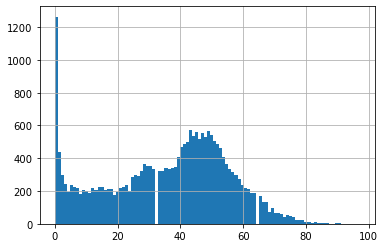

In [ ]:
'''
40 or higher seems to be a decent cutoff
will select the cutoff after the train-test-holdout split though to
keep data leakage at a minimum
'''
track_df['popularity'].hist(bins=100)

<AxesSubplot:>

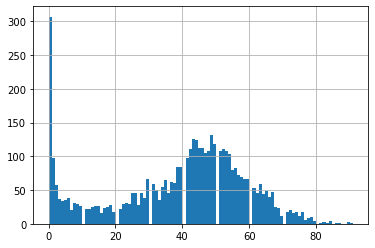

In [ ]:
# songs without mp3s skew slightly more popular
track_df[track_df['preview_url'].isna()]['popularity'].hist(bins=100)

In [ ]:
# Drop duplicate preview mp3s
mp3s = track_df.drop_duplicates(subset=['preview_url'])
mp3s = mp3s.dropna(subset=['preview_url'])

In [ ]:
mp3s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16194 entries, 0 to 22675
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            16194 non-null  object
 1   popularity    16194 non-null  int64 
 2   track         16194 non-null  object
 3   artists       16194 non-null  object
 4   album_name    16194 non-null  object
 5   album_type    16194 non-null  object
 6   release_date  16194 non-null  object
 7   image         16192 non-null  object
 8   duration_ms   16194 non-null  int64 
 9   preview_url   16194 non-null  object
dtypes: int64(2), object(8)
memory usage: 1.4+ MB


<AxesSubplot:>

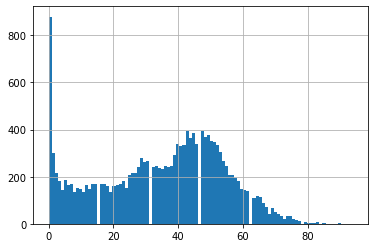

In [ ]:
mp3s['popularity'].hist(bins=100)

<AxesSubplot:>

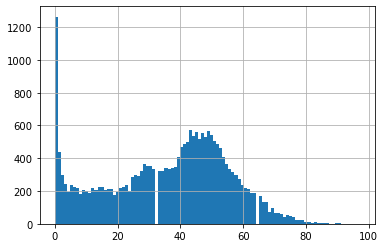

In [ ]:
# songs with preview mp3s and all unique songs collected are distributed about the same
# (despite the above thing being true about no mp3 songs)
track_df['popularity'].hist(bins=100)

In [ ]:
mp3s.to_csv('data/collection_1_mp3s.csv')

In [ ]:
track_df = pd.read_csv('data/collection_1/track_df0.csv', index_col=0)
for i in range(1,500):
    track_df = pd.concat([track_df, 
                          pd.read_csv(f'data/collection_1/track_df{i}.csv', index_col=0)])

In [ ]:
# Drop duplicates across full dataframe
track_df = track_df.drop_duplicates()

In [ ]:
track_df.info()

In [ ]:
# null values
track_df.isna().sum()

In [ ]:
# there are many values with the same index, courtesy of concatenating many DataFrames
track_df.sort_index()

In [ ]:
# resetting the index for the full DataFrame
track_df.reset_index(inplace=True)
track_df.drop(columns='index', inplace=True)

In [ ]:
# checking the 
track_df['artists'] = track_df['artists'].map(lambda x: ast.literal_eval(x))
track_df_expart = track_df.explode('artists')
track_df_expart

In [ ]:
# checking out artists for completeness of data
# really not complete at all but good enough for now. Will investigate more later
track_df_expart[track_df_expart['artists'] == 'Drake']

In [ ]:
# a lot of artists who I'd consider popular are below 70 on average
track_df_expart[track_df_expart['popularity'] >= 40].groupby('artists').mean()\
.sort_values('popularity', ascending=False)

In [ ]:
'''
40 or higher seems to be a decent cutoff
will select the cutoff after the train-test-holdout split though to
keep data leakage at a minimum
'''
track_df['popularity'].hist(bins=100)

In [ ]:
for i in range(1,500):
        print(f'Data chunk #{i}...')
        get_tracks().to_csv(f'data/collection_1/track_df{i}.csv')

Data chunk #35...
Repeat ID Count:
 7521
Data chunk #36...
Repeat ID Count:
 7133
Data chunk #37...
Repeat ID Count:
 7225
Data chunk #38...
Repeat ID Count:
 8315
Data chunk #39...
Repeat ID Count:
 6532
Data chunk #40...
Repeat ID Count:
 6733
Data chunk #41...
Repeat ID Count:
 7959
Data chunk #42...
Repeat ID Count:
 8657
Data chunk #43...
Repeat ID Count:
 8236
Data chunk #44...
Repeat ID Count:
 8735
Data chunk #45...
Repeat ID Count:
 6949
Data chunk #46...
Repeat ID Count:
 9938
Data chunk #47...
Repeat ID Count:
 8442
Data chunk #48...
Repeat ID Count:
 7947
Data chunk #49...
Repeat ID Count:
 9201
Data chunk #50...
Repeat ID Count:
 7203
Data chunk #51...
Repeat ID Count:
 7517
Data chunk #52...
Repeat ID Count:
 8722
Data chunk #53...
Repeat ID Count:
 7621
Data chunk #54...
Repeat ID Count:
 8320
Data chunk #55...
Repeat ID Count:
 7297
Data chunk #56...
Repeat ID Count:
 7975
Data chunk #57...
Repeat ID Count:
 7871
Data chunk #58...
Repeat ID Count:
 7882
Data chunk #59..

Repeat ID Count:
 8141
Data chunk #233...
Repeat ID Count:
 8997
Data chunk #234...
Repeat ID Count:
 6875
Data chunk #235...
Repeat ID Count:
 6763
Data chunk #236...
Repeat ID Count:
 9035
Data chunk #237...
Repeat ID Count:
 7562
Data chunk #238...
Repeat ID Count:
 9142
Data chunk #239...
Repeat ID Count:
 7884
Data chunk #240...
Repeat ID Count:
 8496
Data chunk #241...
Repeat ID Count:
 8276
Data chunk #242...
Repeat ID Count:
 8282
Data chunk #243...
Repeat ID Count:
 7846
Data chunk #244...
Repeat ID Count:
 9606
Data chunk #245...
Repeat ID Count:
 9247
Data chunk #246...
Repeat ID Count:
 6956
Data chunk #247...
Repeat ID Count:
 8056
Data chunk #248...
Repeat ID Count:
 7499
Data chunk #249...
Repeat ID Count:
 7760
Data chunk #250...
Repeat ID Count:
 8172
Data chunk #251...
Repeat ID Count:
 9198
Data chunk #252...
Repeat ID Count:
 8046
Data chunk #253...
Repeat ID Count:
 7978
Data chunk #254...
Repeat ID Count:
 8270
Data chunk #255...
Repeat ID Count:
 8167
Data chunk 

Repeat ID Count:
 8502
Data chunk #429...
Repeat ID Count:
 7432
Data chunk #430...
Repeat ID Count:
 7932
Data chunk #431...
Repeat ID Count:
 8747
Data chunk #432...
Repeat ID Count:
 8352
Data chunk #433...
Repeat ID Count:
 7120
Data chunk #434...
Repeat ID Count:
 7684
Data chunk #435...
Repeat ID Count:
 7743
Data chunk #436...
Repeat ID Count:
 8086
Data chunk #437...
Repeat ID Count:
 8493
Data chunk #438...
Repeat ID Count:
 7842
Data chunk #439...
Repeat ID Count:
 7491
Data chunk #440...
Repeat ID Count:
 8741
Data chunk #441...
Repeat ID Count:
 7382
Data chunk #442...
Repeat ID Count:
 7322
Data chunk #443...
Repeat ID Count:
 7958
Data chunk #444...
Repeat ID Count:
 6807
Data chunk #445...
Repeat ID Count:
 7268
Data chunk #446...
Repeat ID Count:
 7400
Data chunk #447...
Repeat ID Count:
 8188
Data chunk #448...
Repeat ID Count:
 8271
Data chunk #449...
Repeat ID Count:
 8456
Data chunk #450...
Repeat ID Count:
 6150
Data chunk #451...
Repeat ID Count:
 7377
Data chunk 

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.random import set_seed

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.random import set_seed

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.random import set_seed

import numpy as np
import matplotlib.pyplot as plt

In [3]:
import pickle

In [4]:
# Defining a results visualization function
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8), sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

In [5]:
with open('/content/drive/MyDrive/Colab Notebooks/mel_spec_sc.pkl', 'rb') as up:
    mel_spec_sc = pickle.load(up)
X_train, y_train = mel_spec_sc['X_train'][0], mel_spec_sc['X_train'][1]
X_test, y_test = mel_spec_sc['X_test'][0], mel_spec_sc['X_test'][1]
X_holdout, y_holdout = mel_spec_sc['X_holdout'][0], mel_spec_sc['X_holdout'][1]

### First Model - Multilayer Perceptron

In [6]:
input_shape = X_train.shape[1:]
batch_size = X_train.shape[0]/100

In [11]:
input_shape

(128, 1292, 1)

In [ ]:
# set random seed for reproducibility
np.random.seed(42)
set_seed(42)

# build sequentially
mlp = keras.Sequential(name='mlp')

# flatten input 3D tensor to 1D
mlp.add(layers.Flatten(input_shape=input_shape))

# two hidden layers
mlp.add(layers.Dense(128, activation='relu'))
mlp.add(layers.Dense(64, activation='relu'))

# output layer
mlp.add(layers.Dense(1, activation='sigmoid'))

# compile cnn
mlp.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics=['accuracy', 'Recall'])

# take a look at model architecture
mlp.summary()

Model: "mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 165376)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               21168256  
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 21,176,577
Trainable params: 21,176,577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
fsm_history = mlp.fit(X_train, y_train, epochs=60, batch_size=30,
                  validation_data=(X_test, y_test))

Epoch 1/60
346/346 [==============================] - 15s 39ms/step - loss: 2.5842 - accuracy: 0.4952 - recall: 0.4904 - val_loss: 1.5612 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 2/60
346/346 [==============================] - 14s 41ms/step - loss: 0.8632 - accuracy: 0.4939 - recall: 0.4727 - val_loss: 0.7065 - val_accuracy: 0.4885 - val_recall: 0.9991
Epoch 3/60
346/346 [==============================] - 14s 41ms/step - loss: 0.7371 - accuracy: 0.5040 - recall: 0.4894 - val_loss: 0.7026 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 4/60
346/346 [==============================] - 14s 41ms/step - loss: 0.7106 - accuracy: 0.5095 - recall: 0.4975 - val_loss: 0.6937 - val_accuracy: 0.4893 - val_recall: 0.9991
Epoch 5/60
346/346 [==============================] - 14s 41ms/step - loss: 0.7029 - accuracy: 0.4978 - recall: 0.4389 - val_loss: 0.6921 - val_accuracy: 0.5227 - val_recall: 0.9157
Epoch 6/60
346/346 [==============================] - 14s 41ms/step - loss: 0.7130

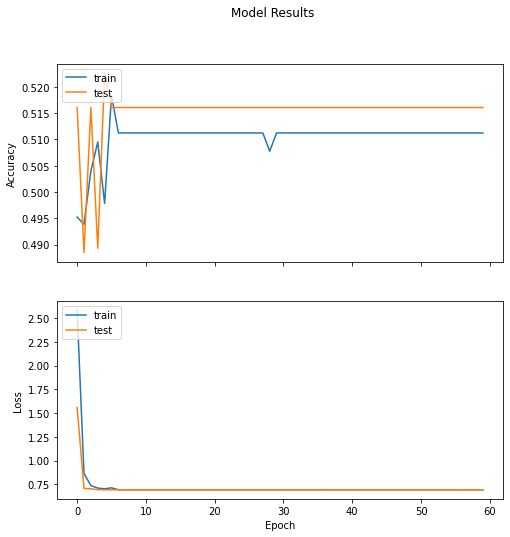

In [ ]:
visualize_training_results(fsm_history)

## CNN

In [ ]:
# set random seed for reproducibility
np.random.seed(42)
set_seed(42)

# build sequentially
cnn1 = keras.Sequential(name='cnn1')

# convolutional and max pooling layers with successively more filters
cnn1.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape))
cnn1.add(layers.MaxPooling2D((2, 4)))

cnn1.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
cnn1.add(layers.MaxPooling2D((2, 4)))

cnn1.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn1.add(layers.MaxPooling2D((2, 2)))

cnn1.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn1.add(layers.MaxPool2D((2, 2)))

# fully-connected layers for output
cnn1.add(layers.Flatten())
cnn1.add(layers.Dense(128, activation='relu'))
cnn1.add(layers.Dropout(0.3))
cnn1.add(layers.Dense(64, activation='relu'))
cnn1.add(layers.Dropout(0.3))

# output layer
cnn1.add(layers.Dense(1, activation='sigmoid'))

# compile cnn
cnn1.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics=['accuracy', 'Recall'])

# take a look at model architecture
cnn1.summary()

Model: "cnn1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 1292, 16)     160       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 323, 16)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 323, 32)       4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 80, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 80, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 40, 64)       0      

In [ ]:
cnn1_history = cnn1.fit(X_train, y_train, epochs=60, batch_size=100,
                  validation_data=(X_test, y_test))

Epoch 1/60
104/104 [==============================] - 191s 2s/step - loss: 0.6937 - accuracy: 0.5081 - recall: 0.0949 - val_loss: 0.6926 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 2/60
104/104 [==============================] - 190s 2s/step - loss: 0.6930 - accuracy: 0.5074 - recall: 0.0497 - val_loss: 0.6929 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 3/60
104/104 [==============================] - 177s 2s/step - loss: 0.6932 - accuracy: 0.5114 - recall: 0.0026 - val_loss: 0.6928 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 4/60
104/104 [==============================] - 166s 2s/step - loss: 0.6929 - accuracy: 0.5112 - recall: 7.8942e-04 - val_loss: 0.6927 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 5/60
104/104 [==============================] - 162s 2s/step - loss: 0.6930 - accuracy: 0.5112 - recall: 0.0000e+00 - val_loss: 0.6927 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 6/60
104/104 [==============================] - 162s 2s/step 

KeyboardInterrupt: ignored

In [ ]:
# set random seed for reproducibility
np.random.seed(42)
set_seed(42)

# build sequentially
cnn2 = keras.Sequential(name='cnn2')

# convolutional and max pooling layers with successively more filters
cnn2.add(layers.Conv2D(32, (2, 3), activation='relu', padding='same', input_shape=input_shape))
cnn2.add(layers.MaxPooling2D((2, 4)))

cnn2.add(layers.Conv2D(64, (2, 3), activation='relu', padding='same'))
cnn2.add(layers.MaxPooling2D((2, 4)))

cnn2.add(layers.Conv2D(128, (2, 3), activation='relu', padding='same'))
cnn2.add(layers.MaxPooling2D((2, 2)))

cnn2.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn2.add(layers.MaxPool2D((2, 2)))

# fully-connected layers for output
cnn2.add(layers.Flatten())
cnn2.add(layers.Dense(128, activation='relu'))
# cnn2.add(layers.Dropout(0.3))
# cnn2.add(layers.Dense(64, activation='relu'))
# cnn2.add(layers.Dropout(0.3))

# output layer
cnn2.add(layers.Dense(1, activation='sigmoid'))

# compile cnn
cnn2.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics=['accuracy', 'Recall'])

# take a look at model architecture
cnn2.summary()

Model: "cnn2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 128, 1292, 32)     224       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 64, 323, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 323, 64)       12352     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 32, 80, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 80, 128)       49280     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 40, 128)      0      

In [ ]:
cnn2_history = cnn2.fit(X_train, y_train, epochs=60, batch_size=100,
                  validation_data=(X_test, y_test))

 51/104 [=============>................] - ETA: 1:52 - loss: 0.4188 - accuracy: 0.7971 - recall: 0.8107

KeyboardInterrupt: ignored

In [ ]:
visualize_training_results(cnn2_history)

NameError: ignored

In [1]:
# set random seed for reproducibility
np.random.seed(42)
set_seed(42)

# build sequentially
cnn3 = keras.Sequential(name='cnn3')

# convolutional and max pooling layers with successively more filters
cnn3.add(layers.Conv2D(32, (2, 3), activation='relu', padding='same', input_shape=input_shape))
cnn3.add(layers.MaxPooling2D((2, 4)))

cnn3.add(layers.Conv2D(64, (2, 3), activation='relu', padding='same'))
cnn3.add(layers.MaxPooling2D((2, 4)))

cnn3.add(layers.Conv2D(128, (2, 3), activation='relu', padding='same'))
cnn3.add(layers.MaxPooling2D((2, 2)))

cnn3.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn3.add(layers.MaxPool2D((2, 2)))

# fully-connected layers for output
cnn3.add(layers.Flatten())
cnn3.add(layers.Dense(128, activation='relu'))
cnn3.add(layers.Dropout(0.3))
cnn3.add(layers.Dense(64, activation='relu'))
cnn3.add(layers.Dropout(0.3))

# output layer
cnn3.add(layers.Dense(1, activation='sigmoid'))

# compile cnn
cnn3.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics=['accuracy', 'Recall'])

# take a look at model architecture
cnn3.summary()

NameError: ignored

In [ ]:
cnn3_history = cnn3.fit(X_train, y_train, epochs=120, batch_size=100,
                  validation_data=(X_test, y_test))

Epoch 1/120
104/104 [==============================] - 235s 2s/step - loss: 0.6933 - accuracy: 0.5073 - recall: 0.2368 - val_loss: 0.6938 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 2/120
104/104 [==============================] - 239s 2s/step - loss: 0.6930 - accuracy: 0.5070 - recall: 0.0967 - val_loss: 0.6932 - val_accuracy: 0.4839 - val_recall: 1.0000
Epoch 3/120
104/104 [==============================] - 231s 2s/step - loss: 0.6933 - accuracy: 0.5126 - recall: 0.0857 - val_loss: 0.6928 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 4/120
104/104 [==============================] - 230s 2s/step - loss: 0.6931 - accuracy: 0.5116 - recall: 0.0020 - val_loss: 0.6927 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 5/120
104/104 [==============================] - 231s 2s/step - loss: 0.6929 - accuracy: 0.5115 - recall: 0.0022 - val_loss: 0.6927 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 6/120
104/104 [==============================] - 233s 2s/step - loss

In [8]:
visualize_training_results(cnn3_history)

NameError: ignored

## RNN

In [23]:
# set random seed for reproducibility
np.random.seed(42)
set_seed(42)

# build sequentially
rnn = keras.Sequential(name='rnn')

# convolutional and max pooling layers with successively more filters
rnn.add(layers.Conv2D(64, (3, 3), activation='elu', padding='same', input_shape=(128, 1292, 1)))
rnn.add(layers.MaxPooling2D((2, 2)))
rnn.add(layers.Dropout(0.1))

rnn.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same'))
rnn.add(layers.MaxPooling2D((4, 2)))
rnn.add(layers.Dropout(0.1))

rnn.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same'))
rnn.add(layers.MaxPooling2D((4, 2)))
rnn.add(layers.Dropout(0.1))

rnn.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same'))
rnn.add(layers.MaxPool2D((4, 2)))
rnn.add(layers.Dropout(0.1))

rnn.add(layers.Reshape((80,128)))
rnn.add(layers.GRU(units=32, dropout=0.3, return_sequences=True))
rnn.add(layers.GRU(units=32, dropout=0.3))

# output layer
rnn.add(layers.Dense(1, activation='sigmoid'))

# compile cnn
rnn.compile(loss='binary_crossentropy',
            optimizer="adam", 
            metrics=['accuracy', 'Recall'])

# take a look at model architecture
rnn.summary()

Model: "rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 128, 1292, 64)     640       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 64, 646, 64)      0         
 g2D)                                                            
                                                                 
 dropout_43 (Dropout)        (None, 64, 646, 64)       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 64, 646, 128)      73856     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 16, 323, 128)     0         
 g2D)                                                            
                                                                 
 dropout_44 (Dropout)        (None, 16, 323, 128)      0       

In [ ]:
rnn_history = rnn.fit(X_train, y_train, epochs=100, batch_size=100,
                  validation_data=(X_test, y_test))

Epoch 1/100
104/104 [==============================] - 1023s 10s/step - loss: 0.6970 - accuracy: 0.5051 - recall: 0.3734 - val_loss: 0.6913 - val_accuracy: 0.5223 - val_recall: 0.2223
Epoch 2/100
104/104 [==============================] - 991s 10s/step - loss: 0.6932 - accuracy: 0.5156 - recall: 0.3278 - val_loss: 0.6940 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 3/100
104/104 [==============================] - 997s 10s/step - loss: 0.6932 - accuracy: 0.5153 - recall: 0.3233 - val_loss: 0.6908 - val_accuracy: 0.5161 - val_recall: 0.0000e+00
Epoch 4/100
104/104 [==============================] - 998s 10s/step - loss: 0.6906 - accuracy: 0.5260 - recall: 0.4703 - val_loss: 0.6883 - val_accuracy: 0.5289 - val_recall: 0.5945
Epoch 5/100
104/104 [==============================] - 1022s 10s/step - loss: 0.6881 - accuracy: 0.5328 - recall: 0.4604 - val_loss: 0.6876 - val_accuracy: 0.5317 - val_recall: 0.0792
Epoch 6/100
104/104 [==============================] - 983s 9s/step - loss:

In [1]:
 visualize_training_results(rnn_history)

NameError: ignored